https://www.kaggle.com/c/cs5785-fall19-final/

In [60]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import csv
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
import string
import sklearn

%pylab inline

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\simir\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\simir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\simir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Populating the interactive namespace from numpy and matplotlib


C:\Users\simir\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [53]:
train_feat = pd.read_csv("cs5785-fall19-final/features_train/features_resnet1000_train.csv", header = None, index_col=None)
train_feat_inter = pd.read_csv("cs5785-fall19-final/features_train/features_resnet1000intermediate_train.csv", header = None, index_col=None)

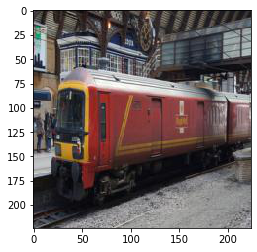

In [24]:
img=mpimg.imread("cs5785-fall19-final/{}".format(train_feat[0][0]))
imgplot = plt.imshow(img)
plt.show()

-----

### Import files

In [15]:
descriptions = []
for i in range(10000):
    with open(('cs5785-fall19-final/descriptions_train/{}.txt').format(i), newline='') as f:
        desc1 = []
        reader = csv.reader(f)
        for row in reader:
            desc1.append(row)
        descriptions.append(desc1)

In [16]:
# FIRST FLATTENING
descriptions2 = []
for description in descriptions:
    descriptions2.append([desc for sublist in description for desc in sublist])

In [17]:
# MADE THE SENTENCES ALL ONE FOR EACH DESCRIPTION FILE
flat_descriptions = []
for description in descriptions2:
    desc1 = []
    for sentence in description:
        desc1 += sentence.split(' ')
    flat_descriptions.append(desc1)

In [18]:
for i in range(len(flat_descriptions)):
    flat_descriptions[i] = (' ').join(flat_descriptions[i]).lower()

In [48]:
# function to preprocess data
def preprocessing(data):
    stop_words = set(stopwords.words('english')) # find stop words in English language
    lemmatizer = WordNetLemmatizer() # declare nltk lemmatizer

    # iterate through every sentence and replace it by itself lemmatized, without punctuation and without stop words
    for i in range(len(data)):
        sentence_no_punct = ''
        # remove punctuation
        
        for char in data[i]:
            if char not in string.punctuation:
                sentence_no_punct = sentence_no_punct + char
        data[i] = sentence_no_punct

        word_tokens = word_tokenize(data[i])
    
        # remove stop words and lemmatize
        word_tokens = [lemmatizer.lemmatize(word) for word in word_tokens if word not in stop_words and len(word) > 1]
        word_tokens = [lemmatizer.lemmatize(word, 'v') for word in word_tokens]
        word_tokens = [lemmatizer.lemmatize(word, 'a') for word in word_tokens]
        
        # remove conjunction words
        word_tokens = [word for word in word_tokens if word[-2:] != 'nt']
        (data[i]) = ' '.join(word_tokens)
        
    return data

In [20]:
# LEMMATIZE EVERYTHING TO GET RID OF REDUNDANCIES
flat_descriptions_pros = preprocessing(flat_descriptions)

In [35]:
# CREATE THE BAG OF WORDS DICTIONARY
BOW = {}
for description in flat_descriptions_pros:
    sentence_lst = description.split(' ')
    for word in sentence_lst:
        BOW[word] = 0
BOW['null'] = 0

In [37]:
# CREATE FEATURE VECTORS
feature_vectors = []
for description in flat_descriptions_pros:
    feat_vec = BOW.copy()
    sentence_lst = description.split(' ')
    for word in sentence_lst:
        if word in feat_vec:
            feat_vec[word] += 1
        else:
            feat_vec['null'] += 1       
    feature_vectors.append(feat_vec)

In [59]:
# TURN DICTIONARIES INTO A MATRIX with each row as one description
feature_vector_matrix = []
for feature_vec in feature_vectors:
    feature_vector_matrix.append(list(feature_vec.values()))

In [61]:
# NORMALIZE THE FEATURES
feature_vector_matrix = sklearn.preprocessing.normalize(feature_vector_matrix) # default is L2 norm

### Try Multilayer Perceptron

In [78]:
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor

cv = KFold(3)

X = feature_vector_matrix
y = train_feat.drop(columns=0).to_numpy()
accuracies = []

for train, test in cv.split(X, y):
    clf = MLPRegressor(solver='sgd', alpha=1e-5, hidden_layer_sizes=(10,10,10), random_state=1)
    clf.fit(X[train], y[train])
    accuracies.append(clf.score(X[test], y[test]))

C:\Users\simir\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\simir\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
C:\Users\simir\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manua

In [79]:
accuracies

[-0.0019355166333799472, -0.000923971163927874, -0.0014772416153607268]

### Keras Neural Net

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [92]:
from sklearn.model_selection import KFold
from tensorflow.keras import losses

cv = KFold(3)

X = feature_vector_matrix
y = train_feat.drop(columns=0).to_numpy()
accuracies = []

for train, test in cv.split(X, y):
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_dim=len(X[0])))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=len(y[0]), activation='softmax'))
    model.compile(loss=losses.mean_squared_error,
              optimizer='sgd',
              metrics=['accuracy'])
    model.fit(X[train], y[train], epochs=5, batch_size=32)
    accuracies.append(model.evaluate(X[test], y[test]))

Train on 6666 samples
Epoch 1/5
6666/6666 [==============================] - 2s 319us/sample - loss: 5.5130 - accuracy: 0.0014
Epoch 2/5
6666/6666 [==============================] - 1s 168us/sample - loss: 5.5130 - accuracy: 0.0014
Epoch 3/5
6666/6666 [==============================] - 1s 164us/sample - loss: 5.5130 - accuracy: 0.0014
Epoch 4/5
6666/6666 [==============================] - 1s 181us/sample - loss: 5.5130 - accuracy: 0.0014
Epoch 5/5
6666/6666 [==============================] - 1s 180us/sample - loss: 5.5130 - accuracy: 0.0014
3334/1 [=============================================================================================================================================================================================================================================================================================================================================================================================================================================================